In [ ]:
# Mount google drive files
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

In [ ]:
# Install packages
!pip install git+https://github.com/seankmartin/NeuroChaT -q
!pip install git+https://github.com/seankmartin/PythonUtils -q
!pip install git+https://github.com/seankmartin/SIMURAN -q
!pip install git+https://github.com/seankmartin/lfp_atn -q
!pip install mne -q
!pip install fooof -q

In [ ]:
# Import libraries
import os
import csv

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import simuran
from lfp_atn_simuran.analysis.frequency_analysis import powers
from fooof import FOOOFGroup

In [ ]:
# Configuration
path_dir = "/content/drive/My Drive/NeuroScience/ATN_CA1"
temp_storage_location = "/content/drive/My Drive/NeuroScience/Temp"
index_location = os.path.join(temp_storage_location, "index.csv")
mapping_params_location = os.path.join(temp_storage_location, "mapping.py")
os.makedirs(os.path.dirname(index_location), exist_ok=True)

nc_loader_kwargs = {
    "system": "Axona",
    "pos_extension": ".pos"
}

clean_kwargs = {
    "pick_property": "group",
    "channels": ["LFP"],
}

all_params = {
    # Cleaning params
    "clean_method": "pick_zscore",
    "clean_kwargs": clean_kwargs,
    
    # Filtering params
    "fmin": 1,
    "fmax": 100,
    "theta_min": 6,
    "theta_max": 10,
    "delta_min": 1.5,
    "delta_max": 4,
    "fmax_plot": 40,

    # Plotting params
    "psd_scale": "decibels",
    "image_format": "png",

    # Path setup
    "cfg_base_dir" : "/content/drive/My Drive/NeuroScience/ATN_CA1",

    # STA
    "number_of_shuffles_sta": 5
}

In [ ]:
# Write out the mapping file

def setup_signals():
    """Set up the signals (such as eeg or lfp)."""

    # The total number of signals in the recording
    num_signals = 32

    # What brain region each signal was recorded from
    regions = ["CA1"] * 32

    # If the wires were bundled, or any other kind of grouping existed
    # If no grouping, grouping = [i for in range(num_signals)]
    groups = ["LFP", "LFP"] + [i for i in range(num_signals - 2)]

    # The sampling rate in Hz of each signal
    sampling_rate = [250] * num_signals

    # This just passes the information on
    output_dict = {
        "num_signals": num_signals,
        "region": regions,
        "group": groups,
        "sampling_rate": sampling_rate,
    }

    return output_dict


def setup_units():
    """Set up the single unit data."""
    # The number of tetrodes, probes, etc - any kind of grouping
    num_groups = 8

    # The region that each group belongs to
    regions = ["CA1"] * num_groups

    # A group number for each group, for example the tetrode number
    groups = [1, 2, 3, 4, 9, 10, 11, 12]

    output_dict = {
        "num_groups": num_groups,
        "region": regions,
        "group": groups,
    }

    return output_dict


def setup_spatial():
    """Set up the spatial data."""

    output_dict = {
        "arena_size": "default",
    }
    return output_dict


def setup_loader():
    """
    Set up the loader and keyword arguments for the loader.

    See also
    --------
    simuran.loaders.loader_list.py

    """
    # The type of loader to use, see simuran.loaders.loader_list.py for options
    loader = "nc_loader"

    output_dict = {
        "loader": loader,
        "loader_kwargs": nc_loader_kwargs,
    }

    return output_dict


load_params = setup_loader()
mapping = {
    "signals": setup_signals(),
    "units": setup_units(),
    "spatial": setup_spatial(),
    "loader": load_params["loader"],
    "loader_kwargs": load_params["loader_kwargs"],
}

ph = simuran.ParamHandler(params=mapping)
ph.write(mapping_params_location)

In [ ]:
# Index the files if not already done
overwrite = False

def add_mapping_to_df(input_df, **kwargs):
    input_df["Mapping"] = [os.path.basename(mapping_params_location)] * len(input_df)
    return input_df

files_df = simuran.index_ephys_files(
    path_dir,
    loader_name="neurochat",
    out_loc=index_location,
    post_process_fn=add_mapping_to_df,
    overwrite=overwrite,
    post_process_kwargs=None,
    loader_kwargs=nc_loader_kwargs,
)

/content/drive/My Drive/NeuroScience/Temp/index.csv exists, so loading this - please delete to reindex or pass overwrite as True.


In [ ]:
# Inspect the files_df
files_df

,Directory,Filename,Time,Duration,Mapping
0,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,090419_open_arena_15min_LCA2.set,14:37:4,900,mapping.py
1,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,050419B_open_arena_15min_LCA2.set,17:25:2,900,mapping.py
2,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,050419_open_arena_15min_LCA2.set,15:30:2,900,mapping.py
3,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,030419_open_arena_15min_LCA2.set,13:05:2,900,mapping.py
4,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,190319_open_arena_15min_LCA2.set,11:27:4,900,mapping.py
5,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,060419_open_arena_15min_LCA2.set,18:10:4,900,mapping.py
6,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,220319_open_arena_15min_LCA2.set,11:44:4,900,mapping.py
7,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,270319_open_arena_15min_LCA2.set,14:55:0,900,mapping.py
8,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,22_10_19_LCA11_50min.set,18:12:5,900,mapping.py
9,/content/drive/My Drive/NeuroScience/ATN_CA1/A...,20_10_19_LCA11_15min.set,20:09:3,900,mapping.py


In [ ]:
# Parse the recording information
rc = simuran.recording_container_from_df(
    files_df,
    base_dir=path_dir,
    param_dir=temp_storage_location
    )

In [ ]:
from skm_pyutils.py_log import get_default_log_loc

log_loc = get_default_log_loc("test.log")
print(log_loc)

/root/.skm_python/test.log


  0%|          | 0/33 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:213: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:213: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/lfp_atn_simuran/analysis/frequency_analysis.py:213: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are re

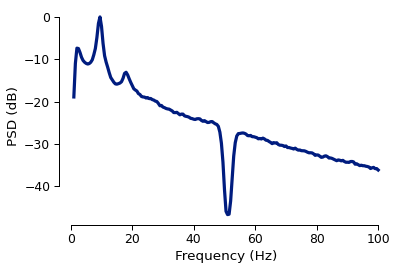

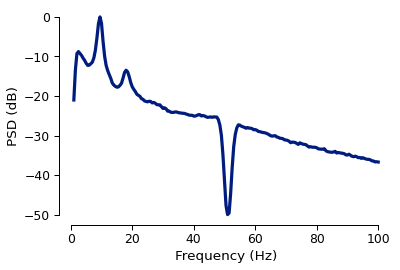

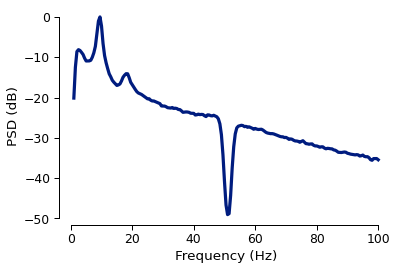

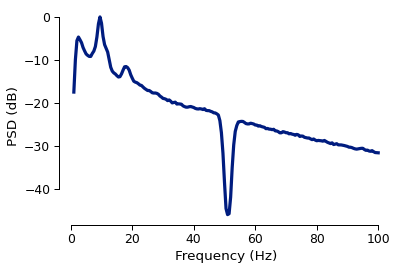

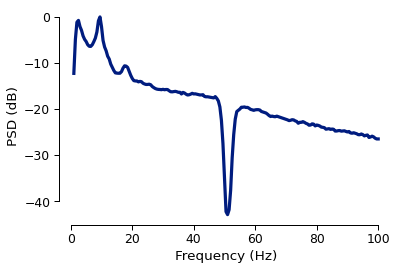

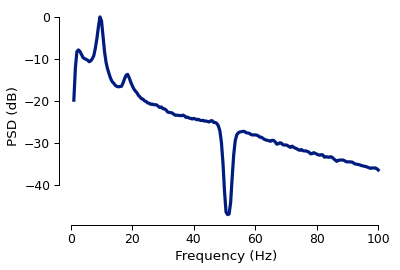

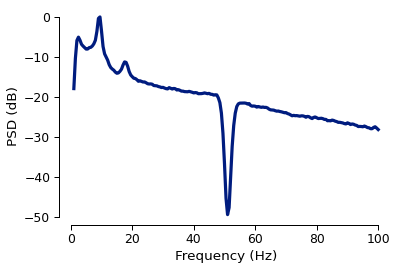

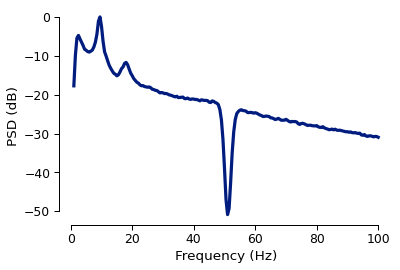

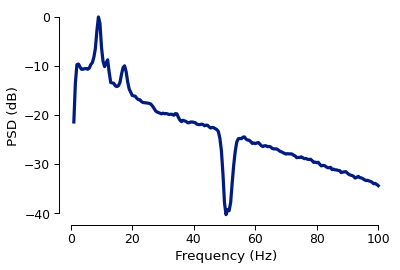

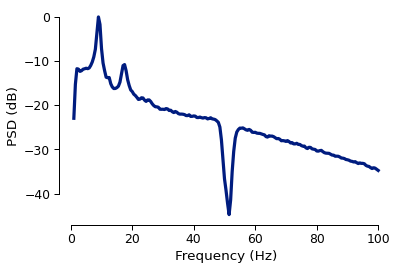

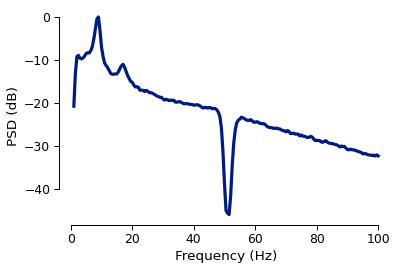

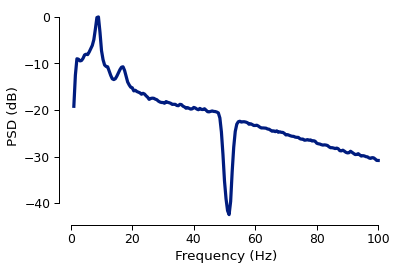

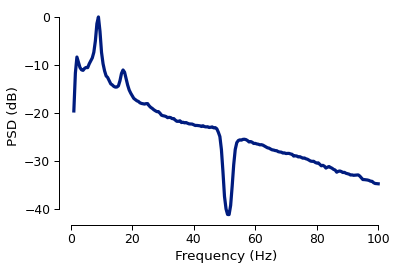

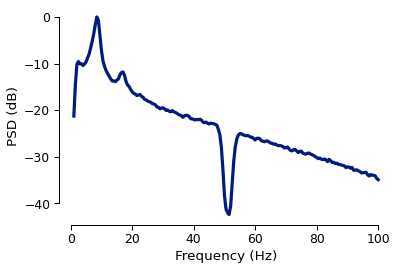

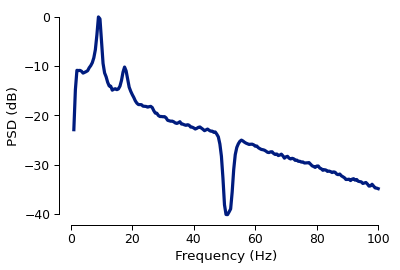

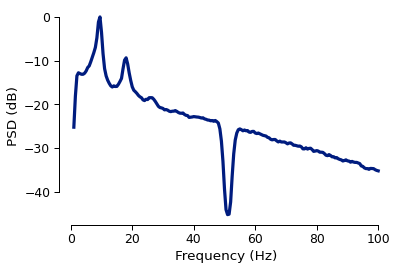

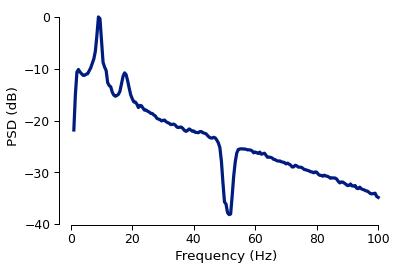

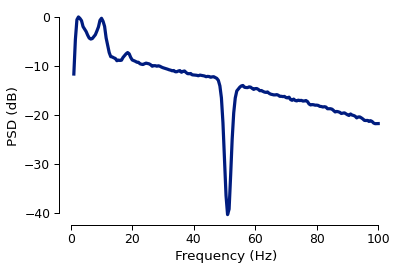

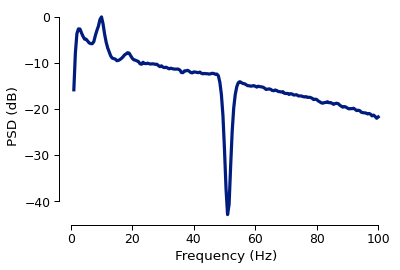

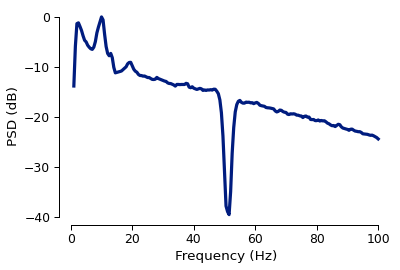

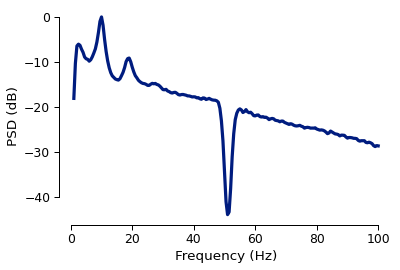

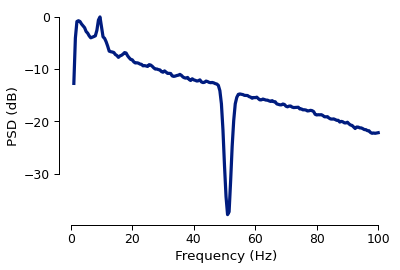

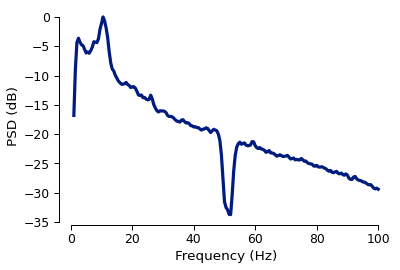

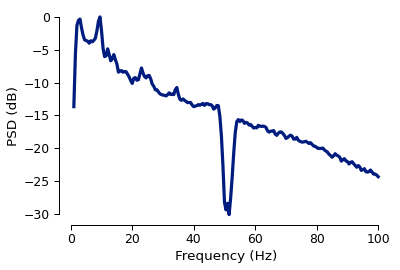

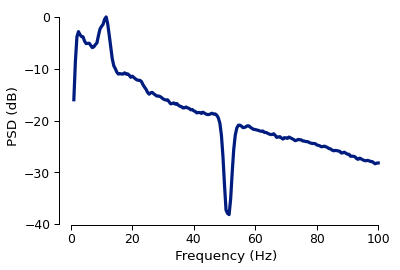

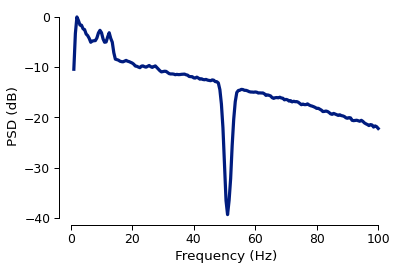

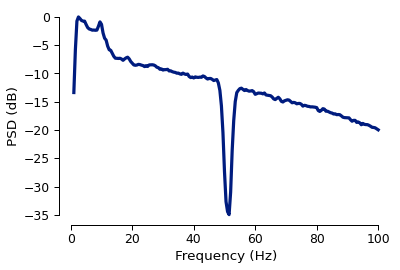

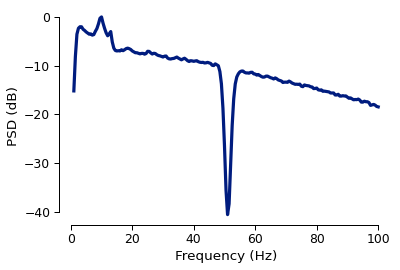

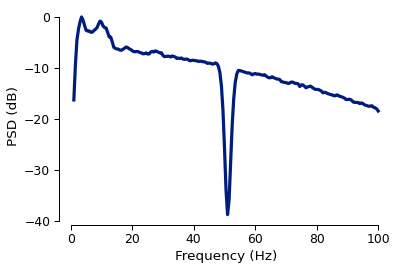

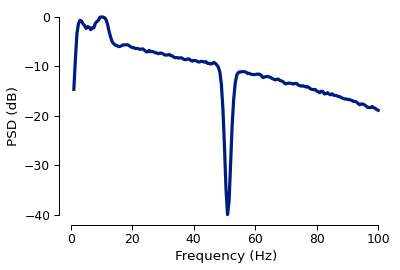

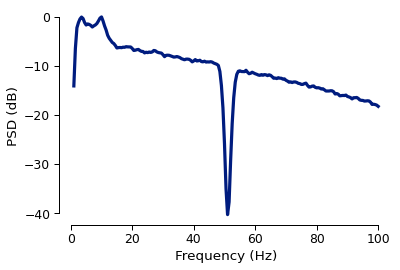

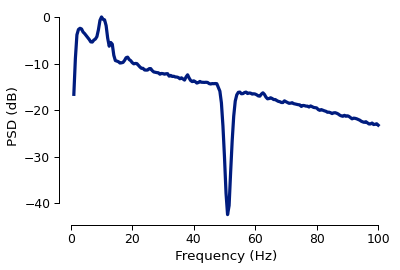

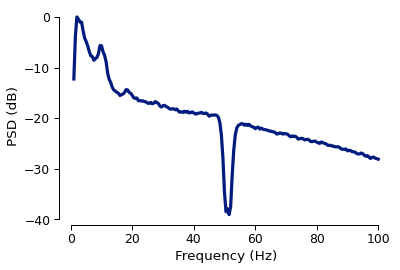

In [ ]:
# Analyse each recording in the container
ah = simuran.AnalysisHandler(handle_errors=True)
sm_figures = []

fn_kwargs = all_params

for r in rc:
    for i in range(len(r.signals)):
        r.signals[i].load()
    fn_args = [r, path_dir, sm_figures]
    ah.add_fn(powers, *fn_args, **fn_kwargs)

ah.run_all_fns(pbar="notebook")

In [ ]:
# Save the analysis results
print(ah)
simuran.save_figures(sm_figures, temp_storage_location, verbose=True)
ah.save_results(os.path.join(temp_storage_location, "results.csv"))

Streaming output truncated to the last 5000 lines.
        '54.0', '54.5', '55.0', '55.5', '56.0', '56.5', '57.0', '57.5',
        '58.0', '58.5', '59.0', '59.5', '60.0', '60.5', '61.0', '61.5',
        '62.0', '62.5', '63.0', '63.5', '64.0', '64.5', '65.0', '65.5',
        '66.0', '66.5', '67.0', '67.5', '68.0', '68.5', '69.0', '69.5',
        '70.0', '70.5', '71.0', '71.5', '72.0', '72.5', '73.0', '73.5',
        '74.0', '74.5', '75.0', '75.5', '76.0', '76.5', '77.0', '77.5',
        '78.0', '78.5', '79.0', '79.5', '80.0', '80.5', '81.0', '81.5',
        '82.0', '82.5', '83.0', '83.5', '84.0', '84.5', '85.0', '85.5',
        '86.0', '86.5', '87.0', '87.5', '88.0', '88.5', '89.0', '89.5',
        '90.0', '90.5', '91.0', '91.5', '92.0', '92.5', '93.0', '93.5',
        '94.0', '94.5', '95.0', '95.5', '96.0', '96.5', '97.0', '97.5',
        '98.0', '98.5', '99.0', '99.5', '100.0'],
       ['-19.85336716780595', '-12.149135251344223',
        '-8.247054191074142', '-7.877807349733343', '-

In [ ]:
class UnicodeGrabber(object):
    """This is a fully static class to get unicode chars for plotting."""
    char_dict = {
        "micro": u"\u00B5",
        "pow2": u"\u00B2",
    }

    @staticmethod
    def get_chars():
        return list(UnicodeGrabber.char_dict.keys())

    @staticmethod
    def get(char, default=""):
        return UnicodeGrabber.char_dict.get(char, default)

In [ ]:
# Combine the results

# First, extract the frequencies and powers
with open(os.path.join(temp_storage_location, "results.csv"), "r") as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar="'")
    welch_freqs = []
    welch_powers = []
    freq_end = 199
    power_end = 2 * freq_end
    max_pxxs = []
    for row in csvreader:
        if row[0] == "CA1 welch":
            values = row[1:]
            freqs = values[:freq_end]
            freqs = np.array([float(f[1:]) for f in freqs])
            powers = values[freq_end:power_end]
            powers = np.array([float(f[1:]) for f in powers])
            welch_freqs.append(freqs)
            welch_powers.append(powers)
        elif row[0] == "CA1 max f":
            val = float(row[1])
            max_pxxs.append(val)
in_list = [np.array(welch_freqs).flatten(), np.array(welch_powers).flatten()]

# Then combine these into a pandas df as
# F, P
df = pd.DataFrame(in_list).T
df.columns = ["frequency", "power"]
df.to_csv(os.path.join(temp_storage_location, "power_results.csv"), index=False)
print(df.head())

   frequency      power
0        1.0 -18.900415
1        1.5 -10.958930
2        2.0  -7.374892
3        2.5  -7.466306
4        3.0  -8.387382


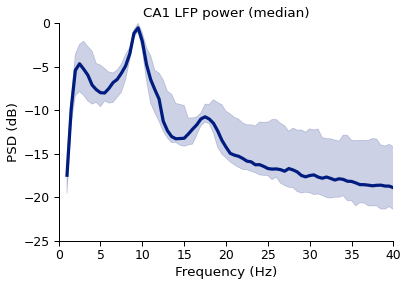

Figure saved to /content/drive/My Drive/NeuroScience/Temp/ca1_power_final_ci.pdf


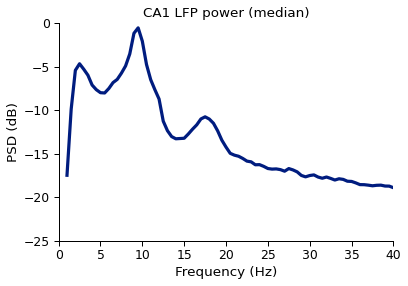

Figure saved to /content/drive/My Drive/NeuroScience/Temp/ca1_power_final.pdf


In [ ]:
## Then use seaborn to produce a summary plot
scale = all_params["psd_scale"]
simuran.set_plot_style()
plt.close("all")
for ci, oname in zip([95, None], ["_ci", ""]):
    out_loc = os.path.join(temp_storage_location, f"ca1_power_final{oname}.pdf")

    sns.lineplot(
            data=df,
            x="frequency",
            y="power",
            ci=ci,
            estimator=np.median,
        )
    plt.xlabel("Frequency (Hz)")
    plt.xlim(0, all_params["fmax_plot"])
    plt.ylim(-25, 0)
    if scale == "volts":
        micro = UnicodeGrabber.get("micro")
        pow2 = UnicodeGrabber.get("pow2")
        plt.ylabel(f"PSD ({micro}V{pow2} / Hz)")
    elif scale == "decibels":
        plt.ylabel("PSD (dB)")
    else:
        raise ValueError("Unsupported scale {}".format(scale))
    plt.title("CA1 LFP power (median)")
    simuran.despine()

    plt.savefig(out_loc, dpi=400,)
    plt.show()
    print(f"Figure saved to {out_loc}")
    plt.close("all")

In [ ]:
# Fooof plots
peaks_data = []
fg = FOOOFGroup(
    peak_width_limits=[1.0, 8.0],
    max_n_peaks=2,
    min_peak_height=0.1,
    peak_threshold=2.0,
    aperiodic_mode="fixed",
)

fooof_arr_s = np.array(welch_powers)
for i in range(len(fooof_arr_s)):
    fooof_arr_s[i] = (np.power(10.0, (fooof_arr_s[i] / 10.0)) * max_pxxs[i])

fooof_arr_f = np.array(welch_freqs)
fg.fit(fooof_arr_f[0], fooof_arr_s, [0.5, 40], progress="tqdm.notebook")

peaks = fg.get_params("peak_params", 0)[:, 0]

for p in peaks:
    peaks_data.append([p, "Control", "CA1"])

peaks_df = pd.DataFrame.from_records(peaks_data, columns=["Peak frequency", "Group", "Region"])

fig, ax = plt.subplots()
sns.histplot(
    data=peaks_df,
    x="Peak frequency",
    # element="step",
    ax=ax,
)
simuran.despine()
out_name = os.path.join(temp_storage_location, "ca1_peaks_fooof.pdf")
fig.savefig(out_name, dpi=400)
plt.close(fig)

Running FOOOFGroup:   0%|          | 0/33 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fooof/objs/group.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for index, data in enumerate(self.group_results)])


In [ ]:
# To see errors, use this
!ln -s /root/.skm_python /root/skm_python